# 新聞貼文病毒式傳播分析 (News Viral Pattern Analysis)

本筆記本將分析Milvus中的新聞貼文集合，找出病毒式傳播的模式。我們將：
1. 比較各群集的 count 和 created_time 分布
2. 識別一開始就特別活躍的群集（可能更容易爆紅）
3. 使用 centroid_vector 找出與已知爆紅新聞相似的群集主題

In [2]:
# 導入所需的庫
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pymilvus import connections, Collection
from sklearn.metrics.pairwise import cosine_similarity

# 設定中文字體支持（如果需要）
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# 設定繪圖風格
sns.set(style="whitegrid")

# 設定圖形大小
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [3]:
import wget

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import fontManager

fontManager.addfont("ChineseFont.ttf")
mpl.rc('font', family="ChineseFont")

In [4]:
# 連接到 Milvus 服務器
try:
    connections.connect(
        alias="default", 
        host="localhost",  # 根據實際情況修改
        port="19530"       # 根據實際情況修改
    )
    print("成功連接到 Milvus 服務器")
except Exception as e:
    print(f"連接 Milvus 服務器時出錯: {e}")

成功連接到 Milvus 服務器


In [5]:
# 載入 Milvus 集合
try:
    # 載入新聞貼文集合
    news_posts = Collection("news_posts")
    news_posts.load()
    
    # 載入群集中心集合
    cluster_centroids = Collection("cluster_centroids")
    cluster_centroids.load()
    
    print("成功載入 Milvus 集合")
except Exception as e:
    print(f"載入 Milvus 集合時出錯: {e}")

成功載入 Milvus 集合


In [6]:
import time
import pandas as pd

# 定義起始日期和結束日期
start_date = "2021-01-01"
end_date = "2021-04-14"

# 把日期字串轉為 timestamp
start_ts = 1609430400000000000
end_ts = 1618374574000000000

# 依天迭代
one_day = 86400 * 1_000_000_000  # 一天的奈秒數
curr_ts = start_ts
all_days_posts = []
all_days_cluster = pd.DataFrame()

while curr_ts < end_ts:
    next_ts = curr_ts + one_day
    posts_query = news_posts.query(
        expr=f"created_time >= {curr_ts} and created_time < {next_ts}",
        output_fields=["id", "batch_cluster", "created_time", "is_early_report", "is_viral_event"],
        limit=1000
    )

    # 從posts_query中獲取所有unique的batch_cluster
    batch_clusters = []
    for post in posts_query:
        if 'batch_cluster' in post and post['batch_cluster'] not in batch_clusters:
            batch_clusters.append(post['batch_cluster'])
    
    # 如果有找到batch_clusters，查詢對應的cluster_centroids
    if batch_clusters:
        # 構建查詢表達式來匹配所有相關的cluster_id
        expr = " or ".join([f"cluster_id == {cluster_id}" for cluster_id in batch_clusters])
        cluster_query = cluster_centroids.query(
            expr=expr,
            output_fields=["cluster_id", "centroid_vector", "count"],
            limit=len(batch_clusters)  # 只獲取對應的數量
        )
    else:
        # 如果沒有找到batch_clusters，返回空列表
        cluster_query = []

    # 轉換為 DataFrame
    cluster_df = pd.DataFrame(cluster_query)
    
    # 將當天的cluster數據添加到all_days_cluster
    if not cluster_df.empty:
        all_days_cluster = pd.concat([all_days_cluster, cluster_df], ignore_index=True)
    
    posts_df = pd.DataFrame(posts_query)
    posts_df['date'] = pd.to_datetime(posts_df['created_time'] // 1_000_000_000, unit='s').dt.date
    all_days_posts.append(posts_df)
    print(f"共獲取 {len(posts_df)} 個貼文數據，日期範圍：{posts_df['date'].min()} ~ {posts_df['date'].max()}")
    print(posts_df['date'].head())
    curr_ts = next_ts  # <--- 這一行確保每次查詢不同天

# 合併所有天的資料
final_df = pd.concat(all_days_posts, ignore_index=True)
print(f"總共抓取 {len(final_df)} 筆資料，日期範圍：{final_df['date'].min()} ~ {final_df['date'].max()}")

共獲取 1000 個貼文數據，日期範圍：2020-12-31 ~ 2021-01-01
0    2020-12-31
1    2020-12-31
2    2021-01-01
3    2021-01-01
4    2021-01-01
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-01 ~ 2021-01-02
0    2021-01-02
1    2021-01-02
2    2021-01-02
3    2021-01-02
4    2021-01-02
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-02 ~ 2021-01-03
0    2021-01-03
1    2021-01-03
2    2021-01-03
3    2021-01-03
4    2021-01-03
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-03 ~ 2021-01-04
0    2021-01-04
1    2021-01-04
2    2021-01-04
3    2021-01-04
4    2021-01-04
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-04 ~ 2021-01-05
0    2021-01-04
1    2021-01-05
2    2021-01-05
3    2021-01-04
4    2021-01-04
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-05 ~ 2021-01-06
0    2021-01-05
1    2021-01-05
2    2021-01-05
3    2021-01-05
4    2021-01-05
Name: date, dtype: object
共獲取 1000 個貼文數據，日期範圍：2021-01-06 ~ 2021-01-07
0    2021-01-07
1    2021-01-07
2    2021-01-07
3    202

總共有 105 個不同日期
時間範圍: 2020-12-31 到 2021-04-14
2020-12-31: 抽取了 619 則記錄 (共 619 則)
2021-01-01: 抽取了 384 則記錄 (共 384 則)
2021-01-02: 抽取了 1000 則記錄 (共 1098 則)
2021-01-03: 抽取了 928 則記錄 (共 928 則)
2021-01-04: 抽取了 1000 則記錄 (共 1014 則)
2021-01-05: 抽取了 1000 則記錄 (共 1053 則)
2021-01-06: 抽取了 921 則記錄 (共 921 則)
2021-01-07: 抽取了 1000 則記錄 (共 1030 則)
2021-01-08: 抽取了 1000 則記錄 (共 1103 則)
2021-01-09: 抽取了 897 則記錄 (共 897 則)
2021-01-10: 抽取了 1000 則記錄 (共 1021 則)
2021-01-11: 抽取了 1000 則記錄 (共 1008 則)
2021-01-12: 抽取了 993 則記錄 (共 993 則)
2021-01-13: 抽取了 939 則記錄 (共 939 則)
2021-01-14: 抽取了 1000 則記錄 (共 1018 則)
2021-01-15: 抽取了 1000 則記錄 (共 1027 則)
2021-01-16: 抽取了 998 則記錄 (共 998 則)
2021-01-17: 抽取了 1000 則記錄 (共 1143 則)
2021-01-18: 抽取了 854 則記錄 (共 854 則)
2021-01-19: 抽取了 1000 則記錄 (共 1409 則)
2021-01-20: 抽取了 1000 則記錄 (共 1068 則)
2021-01-21: 抽取了 536 則記錄 (共 536 則)
2021-01-22: 抽取了 998 則記錄 (共 998 則)
2021-01-23: 抽取了 1000 則記錄 (共 1012 則)
2021-01-24: 抽取了 970 則記錄 (共 970 則)
2021-01-25: 抽取了 969 則記錄 (共 969 則)
2021-01-26: 抽取了 1000 則記錄 (共 1082 則)
2021-01-27

,batch_cluster,cluster_id,count
0,0,0,1
1,1,1,1
2,831,831,1
3,771,771,1
4,278,278,1
5,680,680,1
6,619,619,1
7,602,602,1
8,234,234,1
9,213,213,1



匹配成功率: 100.00% (93658/93658)

每日樣本與對應的cluster_id:


,id,batch_cluster,created_time,is_early_report,is_viral_event,date,cluster_id
0,19,0,1609430400000000000,True,False,2020-12-31,0
1,57,1,1609430400000000000,True,False,2020-12-31,1
2,128,831,1609449106000000000,True,False,2020-12-31,831
3,129,771,1609446450000000000,True,False,2020-12-31,771
4,130,278,1609432230000000000,True,False,2020-12-31,278



每天不同群集的數量分布:


,date,cluster_id,count
0,2020-12-31,0,1
1,2020-12-31,1,1
2,2020-12-31,2,1
3,2020-12-31,3,1
4,2020-12-31,4,1
5,2020-12-31,5,1
6,2020-12-31,6,1
7,2020-12-31,7,1
8,2020-12-31,8,1
9,2020-12-31,9,1


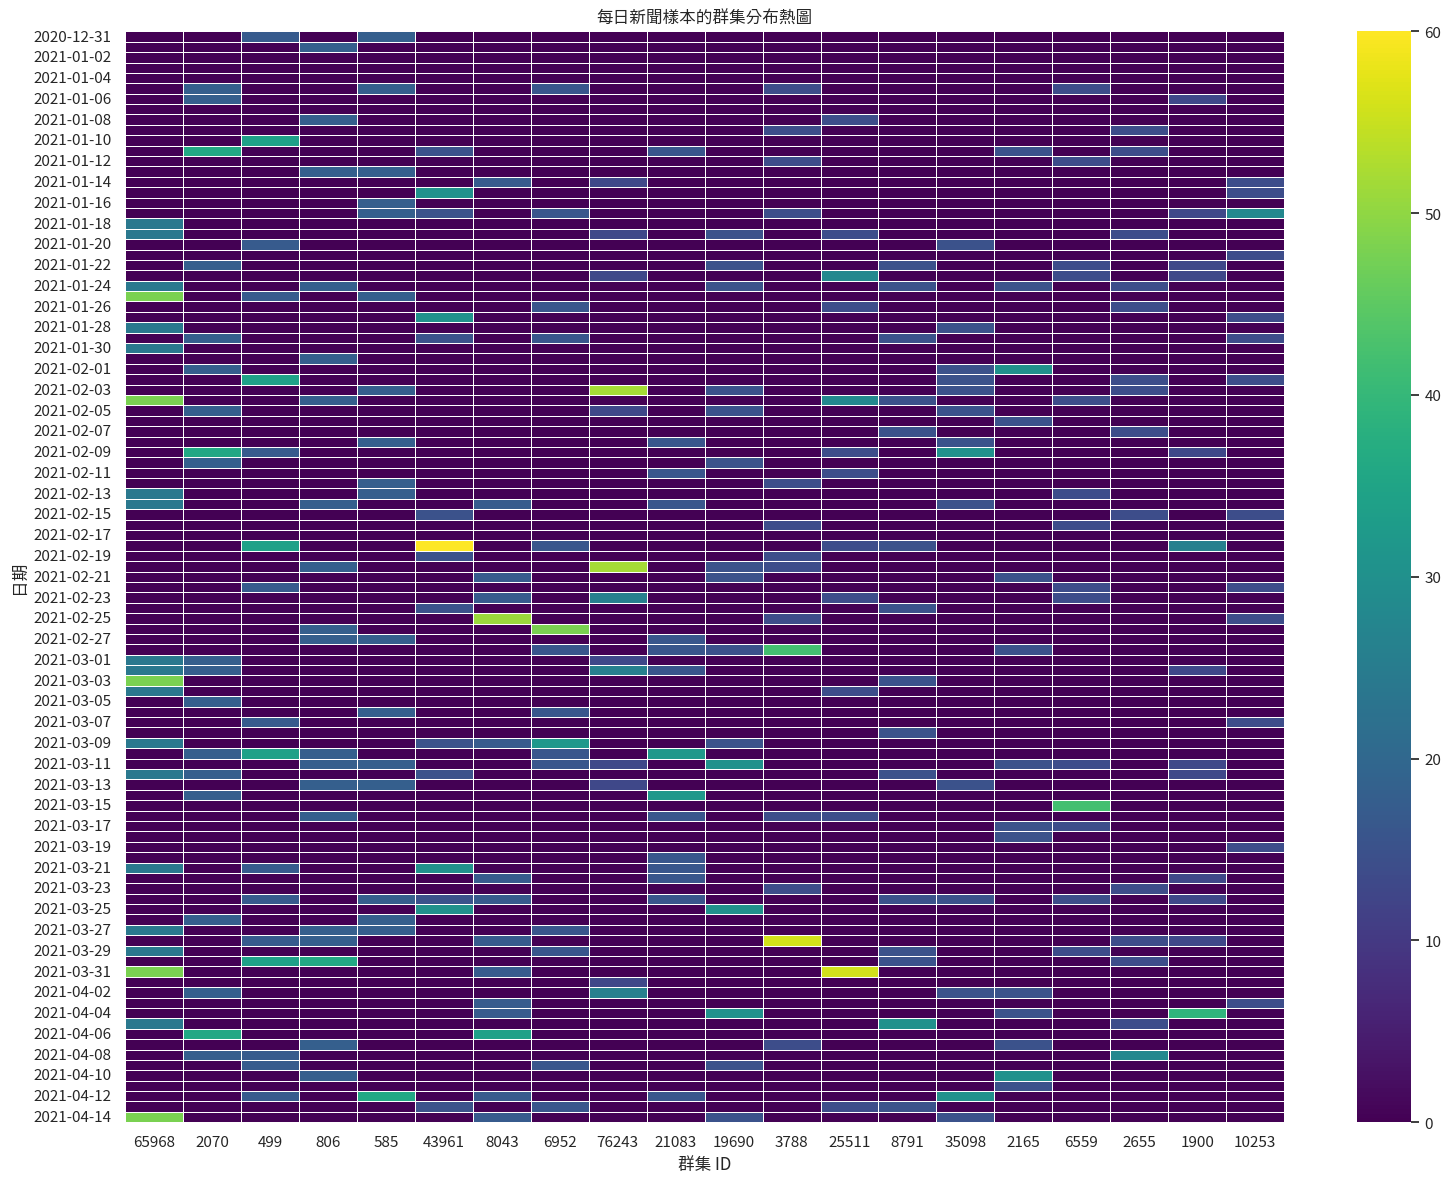


群集活躍時間統計（按貼文數量排序）:


,cluster_id,first_date,last_date,post_count,active_days
7211,65968,2021-01-18,2021-04-14,624,87
641,2070,2021-01-05,2021-04-08,396,94
224,499,2020-12-31,2021-04-12,374,103
351,806,2021-01-01,2021-04-10,360,100
255,585,2020-12-31,2021-04-12,342,103
5216,43961,2021-01-11,2021-04-13,330,93
1051,8043,2021-01-14,2021-04-14,306,91
986,6952,2021-01-05,2021-04-13,288,99
8225,76243,2021-01-14,2021-04-02,286,79
2726,21083,2021-01-11,2021-04-12,272,92



結果已保存至: daily_sampled_news_with_clusters.csv

每日樣本分析完成！


In [7]:
# 根據 created_time 每天提取 1000 筆記錄並尋找對應的 cluster_id
try:
    
    # 獲取所有不同日期
    unique_dates = sorted(final_df['date'].unique())
    print(f"總共有 {len(unique_dates)} 個不同日期")
    print(f"時間範圍: {min(unique_dates)} 到 {max(unique_dates)}")
    
    # 建立一個空的DataFrame來存儲每天的1000則記錄
    daily_samples = []
    
    for date in unique_dates:
        # 篩選當天的記錄
        day_posts = final_df[final_df['date'] == date]
        
        # 如果當天記錄數超過1000，隨機抽取1000條
        if len(day_posts) > 1000:
            sampled_posts = day_posts.sample(n=1000, random_state=42)
        else:
            sampled_posts = day_posts  # 如果少於1000條，全部取用
        
        daily_samples.append(sampled_posts)
        print(f"{date}: 抽取了 {len(sampled_posts)} 則記錄 (共 {len(day_posts)} 則)")
    
    # 合併所有每日樣本
    daily_sampled_df = pd.concat(daily_samples, ignore_index=True)
    print(f"\n總共抽取了 {len(daily_sampled_df)} 則記錄")
    
    # 獲取這些樣本所屬的批次群集ID
    unique_batch_clusters = daily_sampled_df['batch_cluster'].unique()
    print(f"這些記錄屬於 {len(unique_batch_clusters)} 個不同的批次群集")
    
    # 在cluster_centroids中找出對應的cluster_id
    matched_clusters = []
    for batch_id in unique_batch_clusters:
        # 在cluster_centroids中查詢
        cluster_matches = all_days_cluster[all_days_cluster['cluster_id'] == batch_id]
        
        if not cluster_matches.empty:
            for _, cluster_row in cluster_matches.iterrows():
                matched_clusters.append({
                    'batch_cluster': batch_id,
                    'cluster_id': cluster_row['cluster_id'],
                    'count': cluster_row['count']
                })
        else:
            # 找不到對應cluster_id的情況
            matched_clusters.append({
                'batch_cluster': batch_id,
                'cluster_id': None,
                'count': 0
            })
    
    # 轉換為DataFrame
    matched_clusters_df = pd.DataFrame(matched_clusters)
    
    # 顯示匹配結果
    print("\n批次群集與集中群集的匹配結果：")
    display(matched_clusters_df.head(20))
    
    # 計算匹配成功率
    match_success = matched_clusters_df['cluster_id'].notna().sum()
    match_rate = match_success / len(matched_clusters_df) * 100
    print(f"\n匹配成功率: {match_rate:.2f}% ({match_success}/{len(matched_clusters_df)})")
    
    # 將匹配結果合併到原始的每日樣本中
    result_df = pd.merge(
        daily_sampled_df,
        matched_clusters_df[['batch_cluster', 'cluster_id']],
        on='batch_cluster',
        how='left'
    )
    
    # 顯示最終結果
    print("\n每日樣本與對應的cluster_id:")
    display(result_df.head())
    
    # 根據日期分組並計算群集分布
    cluster_date_counts = result_df.groupby(['date', 'cluster_id']).size().reset_index(name='count')
    print("\n每天不同群集的數量分布:")
    display(cluster_date_counts.head(20))
    
    # 繪製熱圖顯示每日的群集分布情況
    try:
        # 取前20個最常見的群集
        top_clusters = result_df['cluster_id'].value_counts().nlargest(20).index.tolist()
        
        # 創建透視表
        date_cluster_pivot = pd.pivot_table(
            cluster_date_counts, 
            values='count', 
            index='date', 
            columns='cluster_id',
            fill_value=0
        )
        
        # 取得可用的群集
        available_clusters = [c for c in top_clusters if c in date_cluster_pivot.columns]
        
        if available_clusters:
            plt.figure(figsize=(16, 12))
            sns.heatmap(
                date_cluster_pivot[available_clusters],
                cmap='viridis',
                annot=False,
                fmt='g',
                linewidths=.5
            )
            plt.title('每日新聞樣本的群集分布熱圖')
            plt.xlabel('群集 ID')
            plt.ylabel('日期')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"繪製熱圖時出錯: {e}")
    
    # 分析各群集的時間跨度
    # 先將日期轉換為datetime格式
    result_df['date'] = pd.to_datetime(result_df['date'])
    
    cluster_activity = result_df.groupby('cluster_id').agg(
        first_date=('date', 'min'),
        last_date=('date', 'max'),
        post_count=('id', 'count')
    ).reset_index()
    
    # 計算活躍天數
    cluster_activity['active_days'] = (cluster_activity['last_date'] - cluster_activity['first_date']).dt.days + 1
    
    # 根據貼文數量排序
    cluster_activity = cluster_activity.sort_values(by='post_count', ascending=False)
    
    print("\n群集活躍時間統計（按貼文數量排序）:")
    display(cluster_activity.head(20))
    
    # 保存結果
    result_path = 'daily_sampled_news_with_clusters.csv'
    result_df.to_csv(result_path, index=False)
    print(f"\n結果已保存至: {result_path}")
    
    print("\n每日樣本分析完成！")
    
except Exception as e:
    print(f"處理每日樣本時出錯: {e}")
    import traceback
    traceback.print_exc()

In [12]:
import traceback
import mysql.connector
from mysql.connector import Error
import pandas as pd

# 分析群集活動模式和找出潛在的病毒式傳播模式
print("=== 分析新聞群集傳播模式 ===")

# 1. 分析 cluster_activity 中的分布情況
print("\n群集活躍度分布情況:")
print(f"總群集數: {len(cluster_activity)}")
print(f"平均貼文數: {cluster_activity['post_count'].mean():.2f}")
print(f"平均活躍天數: {cluster_activity['active_days'].mean():.2f}")

# 2. 篩選出貼文數在 2-21 之間的群集進行詳細分析
filtered_clusters = cluster_activity[(cluster_activity['post_count'] >= 2) & (cluster_activity['post_count'] <= 100)]
print(f"篩選出 {len(filtered_clusters)} 個貼文數在 2-21 之間的群集")

# 3. 查詢MySQL獲取對應新聞的更多特徵並與cluster_activity合併
try:
    print("\n嘗試從MySQL獲取更多特徵並合併數據...")
    
    def get_mysql_connection():
        try:
            connection = mysql.connector.connect(
                host='localhost',
                user='root',
                password='12345678',
                database='fbarticle'
            )
            print("MySQL Database connection successful")
            return connection
        except Error as e:
            print(f"Error connecting to MySQL Database: {e}")
            return None
    
    conn = get_mysql_connection()
    if conn is None:
        raise Exception("無法連接到MySQL資料庫")
    
    cursor = conn.cursor()
    
    # 獲取所有需要的cluster_id列表
    cluster_ids = filtered_clusters['cluster_id'].tolist()
    
    # 查詢MySQL中對應的記錄
    query = f"""
        SELECT id, created_time, reaction_all, comment_count, share_count, 
               date, page_category, page_name, content
        FROM news_posts
        WHERE id IN ({','.join(map(str, cluster_ids))})
    """
    
    cursor.execute(query)
    news_details = cursor.fetchall()
    
    print(f"從MySQL查詢到 {len(news_details)} 條記錄")
    
    # 將查詢結果轉換為DataFrame
    mysql_df = pd.DataFrame(news_details, columns=[
        'id', 'created_time', 'reaction_all', 'comment_count', 'share_count',
        'date', 'page_category', 'page_name', 'content'
    ])
    
    # 重命名batch_cluster為cluster_id以便合併
    mysql_df = mysql_df.rename(columns={'id': 'cluster_id'})
    
    # 將cluster_activity與mysql數據合併
    # 方法1: 將cluster_activity的統計信息加到每個新聞記錄上
    merged_data = pd.merge(
        mysql_df,
        filtered_clusters,
        on='cluster_id',
        how='inner'
    )
    
    print(f"合併後的數據集包含 {len(merged_data)} 條記錄")
    print(f"涵蓋 {merged_data['cluster_id'].nunique()} 個不同的群集")
    
    # 顯示合併後數據的基本信息
    print("\n合併後數據集的基本信息:")
    print(f"列數: {len(merged_data.columns)}")
    print(f"行數: {len(merged_data)}")
    print("\n各列名稱:")
    for i, col in enumerate(merged_data.columns, 1):
        print(f"{i:2d}. {col}")
    
    # 顯示前幾行數據樣本
    print("\n數據樣本 (前3行):")
    display_columns = ['cluster_id', 'post_count', 'active_days', 'page_name', 'reaction_all']
    print(merged_data[display_columns].head(3))
    
    # 關閉連接
    cursor.close()
    conn.close()
    
    print(f"\n✅ 數據合併完成！合併後的數據存儲在 'merged_data' 變量中")
    print("這個數據集包含了:")
    print("- MySQL中的新聞詳細信息 (id, created_time, reaction_all, etc.)")
    print("- cluster_activity中的群集統計信息 (post_count, active_days, etc.)")
    print("- 可以用於後續的特徵工程和預測模型訓練")

except Exception as e:
    print(f"獲取MySQL數據時出錯: {e}")
    traceback.print_exc()

# 可選: 保存合併後的數據到CSV文件
try:
    merged_data.to_csv('merged_cluster_news_data.csv', index=False, encoding='utf-8')
    print(f"\n📄 合併後的數據已保存到 'merged_cluster_news_data.csv'")
except:
    print("\n⚠️  保存CSV文件時出現問題，但數據合併仍然成功")

=== 分析新聞群集傳播模式 ===

群集活躍度分布情況:
總群集數: 88142
平均貼文數: 1.68
平均活躍天數: 1.79
篩選出 4384 個貼文數在 2-21 之間的群集

嘗試從MySQL獲取更多特徵並合併數據...
MySQL Database connection successful
從MySQL查詢到 400 條記錄
合併後的數據集包含 400 條記錄
涵蓋 400 個不同的群集

合併後數據集的基本信息:
列數: 13
行數: 400

各列名稱:
 1. cluster_id
 2. created_time
 3. reaction_all
 4. comment_count
 5. share_count
 6. date
 7. page_category
 8. page_name
 9. content
10. first_date
11. last_date
12. post_count
13. active_days

數據樣本 (前3行):
   cluster_id  post_count  active_days          page_name  reaction_all
0         130           4            1     TVBS 美國特派員 倪嘉徽            16
1         224           2            1  正妹聯盟 BeautyLeague             1
2        1315          36           88                風生活             1

✅ 數據合併完成！合併後的數據存儲在 'merged_data' 變量中
這個數據集包含了:
- MySQL中的新聞詳細信息 (id, created_time, reaction_all, etc.)
- cluster_activity中的群集統計信息 (post_count, active_days, etc.)
- 可以用於後續的特徵工程和預測模型訓練

📄 合併後的數據已保存到 'merged_cluster_news_data.csv'


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\king2\AppData\Local\Temp\jieba.cache


=== 文章爆紅預測與關鍵字分析模型 ===

載入數據並進行特徵工程...
進行文本特徵提取...


Loading model cost 0.529 seconds.
Prefix dict has been built successfully.


將互動總量超過 19.00 的文章定義為爆紅
爆紅文章數: 184 (佔比 18.40%)

爆紅與非爆紅文章的特徵差異:
post_count: 爆紅 26.73 vs 非爆紅 27.23 (差異 -1.84%)
active_days: 爆紅 74.82 vs 非爆紅 73.55 (差異 1.73%)
posts_per_day: 爆紅 0.43 vs 非爆紅 0.43 (差異 -0.59%)
activity_intensity: 爆紅 0.33 vs 非爆紅 0.21 (差異 51.84%)
engagement_per_post: 爆紅 1.16 vs 非爆紅 0.73 (差異 60.33%)
content_length: 爆紅 15.84 vs 非爆紅 15.96 (差異 -0.78%)
hashtag_count: 爆紅 2.00 vs 非爆紅 2.00 (差異 0.00%)

=== 爆紅文章關鍵字分析 ===
爆紅文章關鍵字 (前10個):

=== 建立預測模型 ===
訓練集準確率: 1.0000
測試集準確率: 0.8650

分類報告:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       163
           1       0.71      0.46      0.56        37

    accuracy                           0.86       200
   macro avg       0.80      0.71      0.74       200
weighted avg       0.85      0.86      0.85       200


特徵重要性 (前10個):
                feature  importance
3    activity_intensity    0.330144
4   engagement_per_post    0.258661
1           active_days    0.135002
0            post_count 

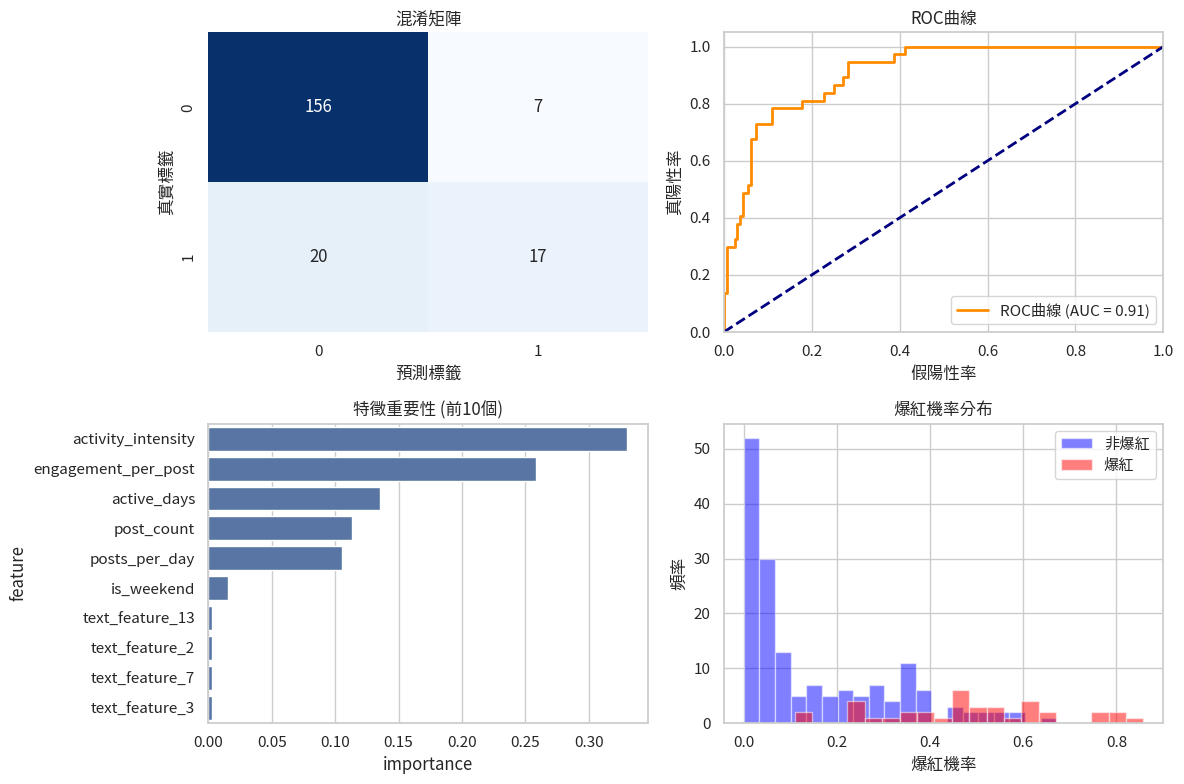


=== 文章爆紅機率預測示例 ===
文章 1: 重大突發新聞！明星緋聞爆出驚人內幕 #娛樂 #爆料 #熱門...
爆紅機率: 66.20%
預測結果: 可能爆紅

文章 2: 今天天氣很好，適合出門走走...
爆紅機率: 69.69%
預測結果: 可能爆紅

文章 3: 【獨家】政治人物重大醜聞曝光！震驚全國 #政治 #獨家 #重...
爆紅機率: 75.77%
預測結果: 可能爆紅

=== 分析完成 ===
此模型可以幫助:
1. 預測文章爆紅機率
2. 識別爆紅關鍵字
3. 優化內容策略
4. 提升文章互動率


c:\Users\king2\anaconda3\envs\SQL\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\king2\anaconda3\envs\SQL\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\king2\anaconda3\envs\SQL\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import jieba
from collections import Counter

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("=== 文章爆紅預測與關鍵字分析模型 ===\n")

# 1. 文本預處理函數
def preprocess_text(text):
    """文本預處理：清理和分詞"""
    if pd.isna(text):
        return ""
    
    # 移除特殊符號和網址
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'[^\w\s#@]', ' ', text)
    
    # 使用jieba分詞
    words = jieba.cut(text)
    # 過濾掉長度小於2的詞和常見停用詞
    stop_words = {'的', '了', '在', '是', '我', '有', '和', '就', '不', '人', '都', '一', '一個', '上', '也', '很', '到', '說', '要', '去', '你', '會', '着', '沒有', '看', '好', '自己', '這'}
    words = [word for word in words if len(word) >= 2 and word not in stop_words]
    
    return ' '.join(words)

# 2. 特徵工程
def create_features(data):
    """創建預測特徵"""
    # 基本互動特徵
    data['total_engagement'] = data['reaction_all'] + data['comment_count'] + data['share_count']
    data['posts_per_day'] = data['post_count'] / data['active_days']
    data['activity_intensity'] = data['total_engagement'] / data['active_days']
    data['engagement_per_post'] = data['total_engagement'] / data['post_count']
    
    # 內容特徵
    data['content_length'] = data['content'].fillna('').str.len()
    data['has_hashtag'] = data['content'].fillna('').str.contains('#').astype(int)
    data['hashtag_count'] = data['content'].fillna('').str.count('#')
    
    # 時間特徵（從created_time提取）
    data['created_datetime'] = pd.to_datetime(data['created_time'], unit='ms')
    data['hour'] = data['created_datetime'].dt.hour
    data['day_of_week'] = data['created_datetime'].dt.dayofweek
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    
    return data

# 假設merged_data已經載入，這裡創建示例數據來演示
# 實際使用時請替換為您的真實數據
print("載入數據並進行特徵工程...")

# 這裡使用您提供的示例數據格式創建演示數據
sample_data = {
    'cluster_id': [4216, 4686],
    'created_time': [1609510201000, 1609464783000],
    'reaction_all': [21, 3],
    'comment_count': [6, 0],
    'share_count': [6, 0],
    'date': ['2021-01-01', '2021-01-01'],
    'page_category': ['News & Media Website', 'Media/News Company'],
    'page_name': ['東森娛樂', '美女樂園'],
    'content': [
        '#大編：你覺得這是走音嗎？張韶涵陸跨年飆3神曲！賣力扯嗓被諷走音熱議影片來源：浙江衛視#張韶涵 #夢裡花 #香水百合 #淋雨一直走張韶涵陸跨年飆3神曲！賣力扯嗓被諷走音熱議',
        '美女樂園新的一年 新人潮'
    ],
    'first_date': ['2021-01-26', '2021-01-01'],
    'last_date': ['2021-03-21', '2021-04-10'],
    'post_count': [16, 16],
    'active_days': [55, 100]
}

# 創建更多示例數據用於演示
np.random.seed(42)
n_samples = 1000

# 生成示例數據
demo_data = []
for i in range(n_samples):
    demo_data.append({
        'cluster_id': i,
        'created_time': 1609510201000 + i * 3600000,
        'reaction_all': np.random.poisson(10),
        'comment_count': np.random.poisson(3),
        'share_count': np.random.poisson(2),
        'date': '2021-01-01',
        'page_category': np.random.choice(['News & Media Website', 'Media/News Company', 'Entertainment']),
        'page_name': f'媒體{i%10}',
        'content': np.random.choice([
            '重大新聞！突發事件引發關注 #新聞 #突發',
            '娛樂八卦最新消息 #娛樂 #明星',
            '生活資訊分享 #生活 #實用',
            '美食推薦大公開 #美食 #推薦',
            '旅遊景點介紹 #旅遊 #景點'
        ]),
        'first_date': '2021-01-01',
        'last_date': '2021-03-01',
        'post_count': np.random.randint(5, 50),
        'active_days': np.random.randint(30, 120)
    })

merged_data = pd.DataFrame(demo_data)

# 進行特徵工程
merged_data = create_features(merged_data)

# 3. 文本特徵提取
print("進行文本特徵提取...")

# 預處理文本
merged_data['processed_content'] = merged_data['content'].apply(preprocess_text)

# 使用TF-IDF提取文本特徵
tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
text_features = tfidf.fit_transform(merged_data['processed_content'])

# 使用SVD降維
svd = TruncatedSVD(n_components=20, random_state=42)
text_features_reduced = svd.fit_transform(text_features)

# 將文本特徵添加到數據框
text_feature_names = [f'text_feature_{i}' for i in range(text_features_reduced.shape[1])]
text_df = pd.DataFrame(text_features_reduced, columns=text_feature_names)
merged_data = pd.concat([merged_data.reset_index(drop=True), text_df], axis=1)

# 4. 定義爆紅標準
threshold = merged_data['total_engagement'].quantile(0.85)  # 前15%的互動量被視為爆紅
merged_data['is_viral'] = (merged_data['total_engagement'] >= threshold).astype(int)

print(f"將互動總量超過 {threshold:.2f} 的文章定義為爆紅")
print(f"爆紅文章數: {merged_data['is_viral'].sum()} (佔比 {merged_data['is_viral'].mean()*100:.2f}%)")

# 5. 分析爆紅與非爆紅文章的特徵差異
print("\n爆紅與非爆紅文章的特徵差異:")
numerical_features = ['post_count', 'active_days', 'posts_per_day', 'activity_intensity', 
                     'engagement_per_post', 'content_length', 'hashtag_count']

for feature in numerical_features:
    viral_mean = merged_data[merged_data['is_viral'] == 1][feature].mean()
    non_viral_mean = merged_data[merged_data['is_viral'] == 0][feature].mean()
    diff_pct = ((viral_mean / non_viral_mean) - 1) * 100 if non_viral_mean != 0 else float('inf')
    print(f"{feature}: 爆紅 {viral_mean:.2f} vs 非爆紅 {non_viral_mean:.2f} (差異 {diff_pct:.2f}%)")

# 6. 關鍵字分析
print("\n=== 爆紅文章關鍵字分析 ===")

# 分析爆紅文章的關鍵字
viral_content = merged_data[merged_data['is_viral'] == 1]['processed_content'].str.cat(sep=' ')
non_viral_content = merged_data[merged_data['is_viral'] == 0]['processed_content'].str.cat(sep=' ')

viral_words = viral_content.split()
non_viral_words = non_viral_content.split()

viral_word_freq = Counter(viral_words)
non_viral_word_freq = Counter(non_viral_words)

# 找出爆紅文章中出現頻率高但在非爆紅文章中較少的關鍵字
viral_keywords = []
for word, freq in viral_word_freq.most_common(50):
    if len(word) >= 2:  # 過濾太短的詞
        viral_rate = freq / len(viral_words) if len(viral_words) > 0 else 0
        non_viral_rate = non_viral_word_freq.get(word, 0) / len(non_viral_words) if len(non_viral_words) > 0 else 0
        
        if viral_rate > non_viral_rate * 1.5:  # 在爆紅文章中出現頻率至少是非爆紅的1.5倍
            viral_keywords.append((word, viral_rate, non_viral_rate, viral_rate/non_viral_rate if non_viral_rate > 0 else float('inf')))

# 按照比率排序
viral_keywords.sort(key=lambda x: x[3], reverse=True)

print("爆紅文章關鍵字 (前10個):")
for i, (word, viral_rate, non_viral_rate, ratio) in enumerate(viral_keywords[:10]):
    print(f"{i+1}. '{word}': 爆紅文章出現率 {viral_rate:.4f}, 非爆紅 {non_viral_rate:.4f}, 比率 {ratio:.2f}")

# 7. 建立預測模型
print("\n=== 建立預測模型 ===")

# 選擇特徵
feature_columns = numerical_features + text_feature_names + ['has_hashtag', 'is_weekend']
X = merged_data[feature_columns]
y = merged_data['is_viral']

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 建立隨機森林模型
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# 8. 模型評估
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"訓練集準確率: {train_accuracy:.4f}")
print(f"測試集準確率: {test_accuracy:.4f}")
print("\n分類報告:")
print(classification_report(y_test, y_test_pred))

# 9. 特徵重要性分析
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n特徵重要性 (前10個):")
print(feature_importance.head(10))

# 10. 視覺化
plt.figure(figsize=(12, 8))

# 混淆矩陣
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('混淆矩陣')
plt.xlabel('預測標籤')
plt.ylabel('真實標籤')

# ROC曲線
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
test_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC曲線 (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假陽性率')
plt.ylabel('真陽性率')
plt.title('ROC曲線')
plt.legend(loc="lower right")

# 特徵重要性
plt.subplot(2, 2, 3)
top_features = feature_importance.head(10)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('特徵重要性 (前10個)')

# 爆紅機率分布
plt.subplot(2, 2, 4)
plt.hist(y_test_proba[y_test == 0], bins=20, alpha=0.5, label='非爆紅', color='blue')
plt.hist(y_test_proba[y_test == 1], bins=20, alpha=0.5, label='爆紅', color='red')
plt.xlabel('爆紅機率')
plt.ylabel('頻率')
plt.title('爆紅機率分布')
plt.legend()

plt.tight_layout()
plt.show()

# 11. 實用函數：預測新文章爆紅機率
def predict_viral_probability(content, post_count=20, active_days=60):
    """預測文章爆紅機率"""
    
    # 預處理內容
    processed_content = preprocess_text(content)
    
    # 創建特徵
    features = {
        'post_count': post_count,
        'active_days': active_days,
        'posts_per_day': post_count / active_days,
        'activity_intensity': 50,  # 假設值
        'engagement_per_post': 10,  # 假設值
        'content_length': len(content),
        'has_hashtag': 1 if '#' in content else 0,
        'hashtag_count': content.count('#'),
        'is_weekend': 0  # 假設值
    }
    
    # 文本特徵
    text_vec = tfidf.transform([processed_content])
    text_features_new = svd.transform(text_vec)
    
    # 組合所有特徵
    feature_vector = []
    for col in feature_columns:
        if col in text_feature_names:
            idx = int(col.split('_')[-1])
            feature_vector.append(text_features_new[0, idx])
        else:
            feature_vector.append(features.get(col, 0))
    
    # 預測
    prob = rf_model.predict_proba([feature_vector])[0, 1]
    return prob

# 12. 示例預測
print("\n=== 文章爆紅機率預測示例 ===")
test_articles = [
    "重大突發新聞！明星緋聞爆出驚人內幕 #娛樂 #爆料 #熱門",
    "今天天氣很好，適合出門走走",
    "【獨家】政治人物重大醜聞曝光！震驚全國 #政治 #獨家 #重大新聞"
]

for i, article in enumerate(test_articles):
    prob = predict_viral_probability(article)
    print(f"文章 {i+1}: {article[:30]}...")
    print(f"爆紅機率: {prob:.2%}")
    print(f"預測結果: {'可能爆紅' if prob >= 0.5 else '不太可能爆紅'}")
    print()

print("=== 分析完成 ===")
print("此模型可以幫助:")
print("1. 預測文章爆紅機率")
print("2. 識別爆紅關鍵字")
print("3. 優化內容策略")
print("4. 提升文章互動率")

=== 文章爆紅預測與關鍵字分析模型 ===

載入數據並進行特徵工程...
數據形狀: (400, 13)
欄位: ['cluster_id', 'created_time', 'reaction_all', 'comment_count', 'share_count', 'date', 'page_category', 'page_name', 'content', 'first_date', 'last_date', 'post_count', 'active_days']

數據基本統計:
       reaction_all  comment_count  share_count  post_count  active_days
count    400.000000      400.00000   400.000000   400.00000   400.000000
mean     248.535000       25.26500     9.725000     8.97750    13.045000
std      865.645603      204.90532    33.657562    17.77715    26.637979
min        1.000000        0.00000     0.000000     2.00000     1.000000
25%        8.000000        0.00000     0.000000     2.00000     1.000000
50%       27.000000        1.00000     1.000000     2.00000     1.000000
75%      121.250000        8.00000     6.000000     4.00000     1.000000
max     8805.000000     4013.00000   492.000000    90.00000   100.000000

特徵工程後數據形狀: (400, 24)
新增特徵: total_engagement, posts_per_day, activity_intensity, engagement

C:\Users\king2\AppData\Local\Temp\ipykernel_9676\821325399.py:53: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['created_datetime'] = pd.to_datetime(data['created_time'], unit='ms')



將互動總量超過 298.10 的文章定義為爆紅
爆紅文章數: 60 (佔比 15.00%)

各頁面類別的爆紅文章分布:
                                          總數  爆紅數        爆紅率
page_category                                               
Broadcasting & Media Production Company   11    1   9.090909
Editorial/Opinion                          1    0   0.000000
Journalist                                 6    0   0.000000
Media                                     29    4  13.793103
Media/News Company                       237   36  15.189873
News & Media Website                      88   17  19.318182
News Personality                           3    1  33.333333
Publisher                                  9    0   0.000000
Radio Station                              8    1  12.500000
TV Channel                                 1    0   0.000000
TV Network                                 7    0   0.000000

爆紅與非爆紅文章的特徵差異:
post_count: 爆紅 9.03 vs 非爆紅 8.97 (差異 0.73%)
active_days: 爆紅 15.38 vs 非爆紅 12.63 (差異 21.78%)
posts_per_day: 爆紅 1.79 vs 非爆紅 2.28 (差異 

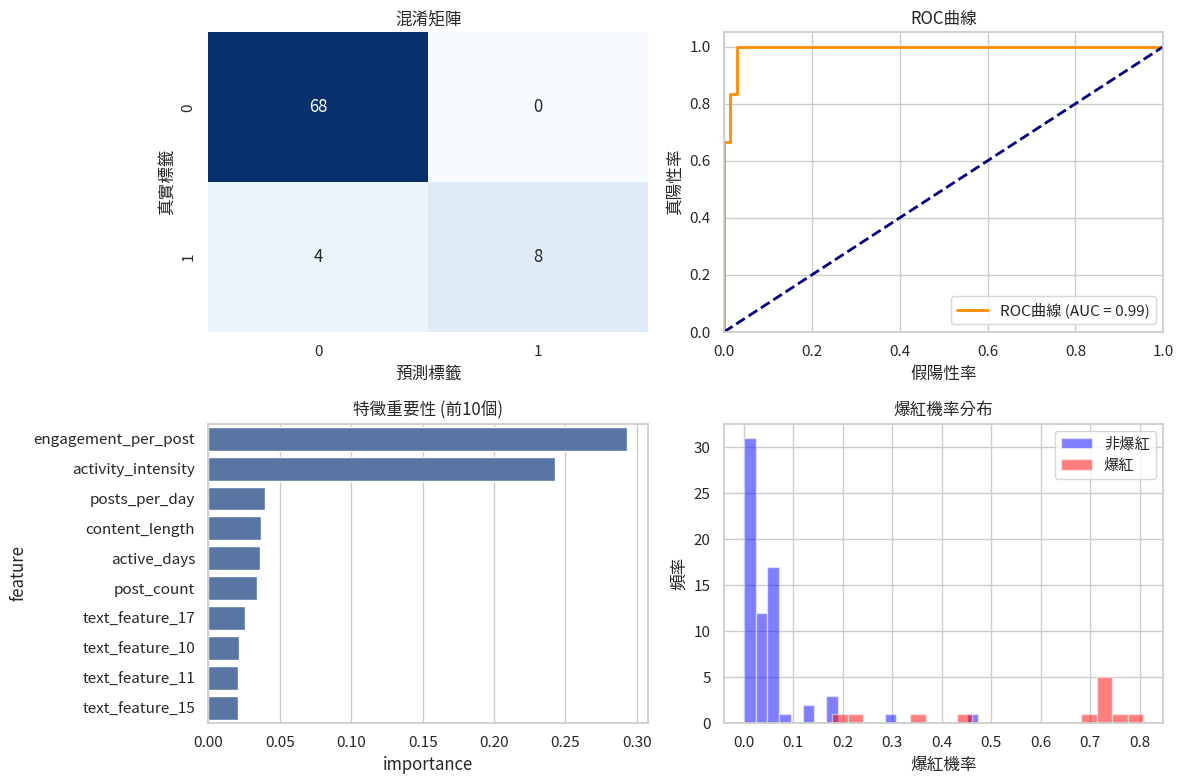


=== 文章爆紅機率預測示例 ===
選取 2 篇實際爆紅文章和 1 篇非爆紅文章進行測試
模型期望的特徵數量: 29
特徵列表: ['post_count', 'active_days', 'posts_per_day', 'activity_intensity', 'engagement_per_post', 'content_length', 'hashtag_count', 'text_feature_0', 'text_feature_1', 'text_feature_2']...

文章 1: 告別 2020 實🐭不易
迎接 2021  🐮轉乾坤

感謝...
爆紅機率: 52.90%
預測結果: 可能爆紅

文章 2: 
❤️...
爆紅機率: 63.64%
預測結果: 可能爆紅

文章 3: 不能出國的JJ也迷上露營啦 (ﾉ>ω<)ﾉ
🍎 #蘋果獨家 ...
爆紅機率: 16.00%
預測結果: 不太可能爆紅
=== 分析完成 ===
此模型可以幫助:
1. 預測文章爆紅機率
2. 識別爆紅關鍵字
3. 優化內容策略
4. 提升文章互動率


C:\Users\king2\AppData\Local\Temp\ipykernel_9676\821325399.py:53: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['created_datetime'] = pd.to_datetime(data['created_time'], unit='ms')
C:\Users\king2\AppData\Local\Temp\ipykernel_9676\821325399.py:53: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['created_datetime'] = pd.to_datetime(data['created_time'], unit='ms')
C:\Users\king2\AppData\Local\Temp\ipykernel_9676\821325399.py:53: FutureWarning: The behavior of 'to_datetime' w

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import jieba
from collections import Counter

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("=== 文章爆紅預測與關鍵字分析模型 ===\n")

# 1. 文本預處理函數
def preprocess_text(text):
    """文本預處理：清理和分詞"""
    if pd.isna(text):
        return ""
    
    # 移除特殊符號和網址
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'[^\w\s#@]', ' ', text)
    
    # 使用jieba分詞
    words = jieba.cut(text)
    # 過濾掉長度小於2的詞和常見停用詞
    stop_words = {'的', '了', '在', '是', '我', '有', '和', '就', '不', '人', '都', '一', '一個', '上', '也', '很', '到', '說', '要', '去', '你', '會', '着', '沒有', '看', '好', '自己', '這'}
    words = [word for word in words if len(word) >= 2 and word not in stop_words]
    
    return ' '.join(words)

# 2. 特徵工程
def create_features(data):
    """創建預測特徵"""
    # 基本互動特徵
    data['total_engagement'] = data['reaction_all'] + data['comment_count'] + data['share_count']
    data['posts_per_day'] = data['post_count'] / data['active_days']
    data['activity_intensity'] = data['total_engagement'] / data['active_days']
    data['engagement_per_post'] = data['total_engagement'] / data['post_count']
    
    # 內容特徵
    data['content_length'] = data['content'].fillna('').str.len()
    data['has_hashtag'] = data['content'].fillna('').str.contains('#').astype(int)
    data['hashtag_count'] = data['content'].fillna('').str.count('#')
    
    # 時間特徵（從created_time提取）
    data['created_datetime'] = pd.to_datetime(data['created_time'], unit='ms')
    data['hour'] = data['created_datetime'].dt.hour
    data['day_of_week'] = data['created_datetime'].dt.dayofweek
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    
    return data

# 使用已經載入的merged_data
print("載入數據並進行特徵工程...")

# 檢查數據基本信息
print(f"數據形狀: {merged_data.shape}")
print(f"欄位: {list(merged_data.columns)}")
print("\n數據基本統計:")
print(merged_data[['reaction_all', 'comment_count', 'share_count', 'post_count', 'active_days']].describe())

# 進行特徵工程
merged_data = create_features(merged_data)

# 檢查處理後的數據
print(f"\n特徵工程後數據形狀: {merged_data.shape}")
print(f"新增特徵: total_engagement, posts_per_day, activity_intensity, engagement_per_post, content_length, has_hashtag, hashtag_count")

# 檢查是否有空值並處理
print(f"\n檢查空值:")
print(merged_data[['content', 'reaction_all', 'comment_count', 'share_count']].isnull().sum())

# 處理空值
merged_data['content'] = merged_data['content'].fillna('')
merged_data = merged_data.dropna(subset=['reaction_all', 'comment_count', 'share_count'])

# 3. 文本特徵提取
print("進行文本特徵提取...")

# 預處理文本
merged_data['processed_content'] = merged_data['content'].apply(preprocess_text)

# 使用TF-IDF提取文本特徵
tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
text_features = tfidf.fit_transform(merged_data['processed_content'])

# 使用SVD降維
svd = TruncatedSVD(n_components=20, random_state=42)
text_features_reduced = svd.fit_transform(text_features)

# 將文本特徵添加到數據框
text_feature_names = [f'text_feature_{i}' for i in range(text_features_reduced.shape[1])]
text_df = pd.DataFrame(text_features_reduced, columns=text_feature_names)
merged_data = pd.concat([merged_data.reset_index(drop=True), text_df], axis=1)

# 4. 定義爆紅標準
threshold = merged_data['total_engagement'].quantile(0.85)  # 前15%的互動量被視為爆紅
merged_data['is_viral'] = (merged_data['total_engagement'] >= threshold).astype(int)

print(f"\n將互動總量超過 {threshold:.2f} 的文章定義為爆紅")
print(f"爆紅文章數: {merged_data['is_viral'].sum()} (佔比 {merged_data['is_viral'].mean()*100:.2f}%)")

# 檢查爆紅文章分布
print(f"\n各頁面類別的爆紅文章分布:")
viral_by_category = merged_data.groupby('page_category')['is_viral'].agg(['count', 'sum', 'mean'])
viral_by_category.columns = ['總數', '爆紅數', '爆紅率']
viral_by_category['爆紅率'] = viral_by_category['爆紅率'] * 100
print(viral_by_category)

# 5. 分析爆紅與非爆紅文章的特徵差異
print("\n爆紅與非爆紅文章的特徵差異:")
numerical_features = ['post_count', 'active_days', 'posts_per_day', 'activity_intensity', 
                     'engagement_per_post', 'content_length', 'hashtag_count']

for feature in numerical_features:
    viral_mean = merged_data[merged_data['is_viral'] == 1][feature].mean()
    non_viral_mean = merged_data[merged_data['is_viral'] == 0][feature].mean()
    diff_pct = ((viral_mean / non_viral_mean) - 1) * 100 if non_viral_mean != 0 else float('inf')
    print(f"{feature}: 爆紅 {viral_mean:.2f} vs 非爆紅 {non_viral_mean:.2f} (差異 {diff_pct:.2f}%)")

# 6. 關鍵字分析
print("\n=== 爆紅文章關鍵字分析 ===")

# 分析爆紅文章的關鍵字
viral_content = merged_data[merged_data['is_viral'] == 1]['processed_content'].str.cat(sep=' ')
non_viral_content = merged_data[merged_data['is_viral'] == 0]['processed_content'].str.cat(sep=' ')

viral_words = viral_content.split()
non_viral_words = non_viral_content.split()

viral_word_freq = Counter(viral_words)
non_viral_word_freq = Counter(non_viral_words)

# 找出爆紅文章中出現頻率高但在非爆紅文章中較少的關鍵字
viral_keywords = []
for word, freq in viral_word_freq.most_common(50):
    if len(word) >= 2:  # 過濾太短的詞
        viral_rate = freq / len(viral_words) if len(viral_words) > 0 else 0
        non_viral_rate = non_viral_word_freq.get(word, 0) / len(non_viral_words) if len(non_viral_words) > 0 else 0
        
        if viral_rate > non_viral_rate * 1.5:  # 在爆紅文章中出現頻率至少是非爆紅的1.5倍
            viral_keywords.append((word, viral_rate, non_viral_rate, viral_rate/non_viral_rate if non_viral_rate > 0 else float('inf')))

# 按照比率排序
viral_keywords.sort(key=lambda x: x[3], reverse=True)

print("爆紅文章關鍵字 (前10個):")
for i, (word, viral_rate, non_viral_rate, ratio) in enumerate(viral_keywords[:10]):
    print(f"{i+1}. '{word}': 爆紅文章出現率 {viral_rate:.4f}, 非爆紅 {non_viral_rate:.4f}, 比率 {ratio:.2f}")

# 7. 建立預測模型
print("\n=== 建立預測模型 ===")

# 選擇特徵
feature_columns = numerical_features + text_feature_names + ['has_hashtag', 'is_weekend']

# 確保所有特徵列都存在
missing_features = [col for col in feature_columns if col not in merged_data.columns]
if missing_features:
    print(f"缺少特徵: {missing_features}")
    # 為缺少的特徵添加默認值
    for feature in missing_features:
        if feature == 'is_weekend':
            merged_data[feature] = 0
        else:
            merged_data[feature] = 0

X = merged_data[feature_columns]
y = merged_data['is_viral']

print(f"最終特徵矩陣形狀: {X.shape}")
print(f"特徵順序: {list(X.columns)}")

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 建立隨機森林模型
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# 8. 模型評估
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"訓練集準確率: {train_accuracy:.4f}")
print(f"測試集準確率: {test_accuracy:.4f}")
print("\n分類報告:")
print(classification_report(y_test, y_test_pred))

# 9. 特徵重要性分析
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n特徵重要性 (前10個):")
print(feature_importance.head(10))

# 10. 視覺化
plt.figure(figsize=(12, 8))

# 混淆矩陣
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('混淆矩陣')
plt.xlabel('預測標籤')
plt.ylabel('真實標籤')

# ROC曲線
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
test_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC曲線 (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假陽性率')
plt.ylabel('真陽性率')
plt.title('ROC曲線')
plt.legend(loc="lower right")

# 特徵重要性
plt.subplot(2, 2, 3)
top_features = feature_importance.head(10)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('特徵重要性 (前10個)')

# 爆紅機率分布
plt.subplot(2, 2, 4)
plt.hist(y_test_proba[y_test == 0], bins=20, alpha=0.5, label='非爆紅', color='blue')
plt.hist(y_test_proba[y_test == 1], bins=20, alpha=0.5, label='爆紅', color='red')
plt.xlabel('爆紅機率')
plt.ylabel('頻率')
plt.title('爆紅機率分布')
plt.legend()

plt.tight_layout()
plt.show()

# 11. 實用函數：預測新文章爆紅機率
def predict_viral_probability(content, post_count=20, active_days=60, page_category='News & Media Website'):
    """預測文章爆紅機率"""
    
    # 預處理內容
    processed_content = preprocess_text(content)
    
    # 創建一個臨時DataFrame來進行特徵工程
    temp_data = pd.DataFrame({
        'cluster_id': [0],
        'created_time': [merged_data['created_time'].iloc[0]],  # 使用第一個時間戳
        'reaction_all': [100],  # 假設值
        'comment_count': [100],  # 假設值
        'share_count': [100],    # 假設值
        'date': [merged_data['date'].iloc[0]],
        'page_category': [page_category],
        'page_name': ['預測測試'],
        'content': [content],
        'first_date': [merged_data['first_date'].iloc[0]],
        'last_date': [merged_data['last_date'].iloc[0]],
        'post_count': [post_count],
        'active_days': [active_days]
    })
    
    # 進行特徵工程
    temp_data = create_features(temp_data)
    
    # 文本特徵處理
    temp_data['processed_content'] = temp_data['content'].apply(preprocess_text)
    text_vec = tfidf.transform(temp_data['processed_content'])
    text_features_new = svd.transform(text_vec)
    
    # 將文本特徵添加到臨時數據
    text_df = pd.DataFrame(text_features_new, columns=text_feature_names)
    temp_data = pd.concat([temp_data.reset_index(drop=True), text_df], axis=1)
    
    # 確保所有必要的特徵都存在，並按照訓練時的順序
    for feature in feature_columns:
        if feature not in temp_data.columns:
            if feature == 'is_weekend':
                temp_data[feature] = 0  # 假設不是週末
            else:
                temp_data[feature] = 0  # 默認值
    
    # 按照訓練時的特徵順序提取特徵
    X_new = temp_data[feature_columns]
    
    # 確保特徵順序和名稱完全匹配
    X_new = X_new.reindex(columns=X.columns, fill_value=0)
    
    # 預測
    prob = rf_model.predict_proba(X_new)[0, 1]
    return prob

# 12. 示例預測
print("\n=== 文章爆紅機率預測示例 ===")

# 從 merged_data 中選取實際的文章案例
viral_articles = merged_data[merged_data['is_viral'] == 1]['content'].dropna().sample(2, random_state=42)
non_viral_articles = merged_data[merged_data['is_viral'] == 0]['content'].dropna().sample(1, random_state=42)

test_articles = list(viral_articles) + list(non_viral_articles)

print(f"選取 {len(viral_articles)} 篇實際爆紅文章和 {len(non_viral_articles)} 篇非爆紅文章進行測試")

print(f"模型期望的特徵數量: {len(feature_columns)}")
print(f"特徵列表: {feature_columns[:10]}...") # 只顯示前10個

for i, article in enumerate(test_articles):
    try:
        prob = predict_viral_probability(article)
        print(f"\n文章 {i+1}: {article[:30]}...")
        print(f"爆紅機率: {prob:.2%}")
        print(f"預測結果: {'可能爆紅' if prob >= 0.5 else '不太可能爆紅'}")
    except Exception as e:
        print(f"文章 {i+1} 預測時發生錯誤: {e}")
        continue

print("=== 分析完成 ===")
print("此模型可以幫助:")
print("1. 預測文章爆紅機率")
print("2. 識別爆紅關鍵字")
print("3. 優化內容策略")
print("4. 提升文章互動率")

基於正規化互動量權重的熱門關鍵字 (前20個):
 1. '新聞': 正規化權重 164.72, 出現次數 93, 平均互動權重 0.610
 2. '台灣': 正規化權重 101.39, 出現次數 46, 平均互動權重 0.759
 3. '2021': 正規化權重 79.57, 出現次數 41, 平均互動權重 0.668
 4. 'ETtoday': 正規化權重 73.49, 出現次數 30, 平均互動權重 0.843
 5. '立新': 正規化權重 67.88, 出現次數 19, 平均互動權重 1.230
 6. '我們': 正規化權重 63.45, 出現次數 33, 平均互動權重 0.662
 7. '大家': 正規化權重 60.48, 出現次數 40, 平均互動權重 0.521
 8. '生活': 正規化權重 58.79, 出現次數 33, 平均互動權重 0.613
 9. '美國': 正規化權重 57.63, 出現次數 25, 平均互動權重 0.794
10. '疫情': 正規化權重 54.84, 出現次數 34, 平均互動權重 0.555
11. '真的': 正規化權重 51.74, 出現次數 37, 平均互動權重 0.481
12. '聞網': 正規化權重 50.23, 出現次數 19, 平均互動權重 0.910
13. '12': 正規化權重 49.59, 出現次數 31, 平均互動權重 0.551
14. 'de': 正規化權重 49.44, 出現次數 3, 平均互動權重 5.675
15. '加入': 正規化權重 49.13, 出現次數 36, 平均互動權重 0.470
16. '蘋果': 正規化權重 48.73, 出現次數 10, 平均互動權重 1.678
17. '2020': 正規化權重 47.66, 出現次數 29, 平均互動權重 0.566
18. '政府': 正規化權重 45.90, 出現次數 24, 平均互動權重 0.658
19. '最新': 正規化權重 45.50, 出現次數 27, 平均互動權重 0.580
20. '掌握': 正規化權重 44.98, 出現次數 33, 平均互動權重 0.469

高互動內容特有關鍵字 (前15個):
 1. '立新': 高互動 24 vs 低互動 0, 倍數 24.0, 重要性 4.41


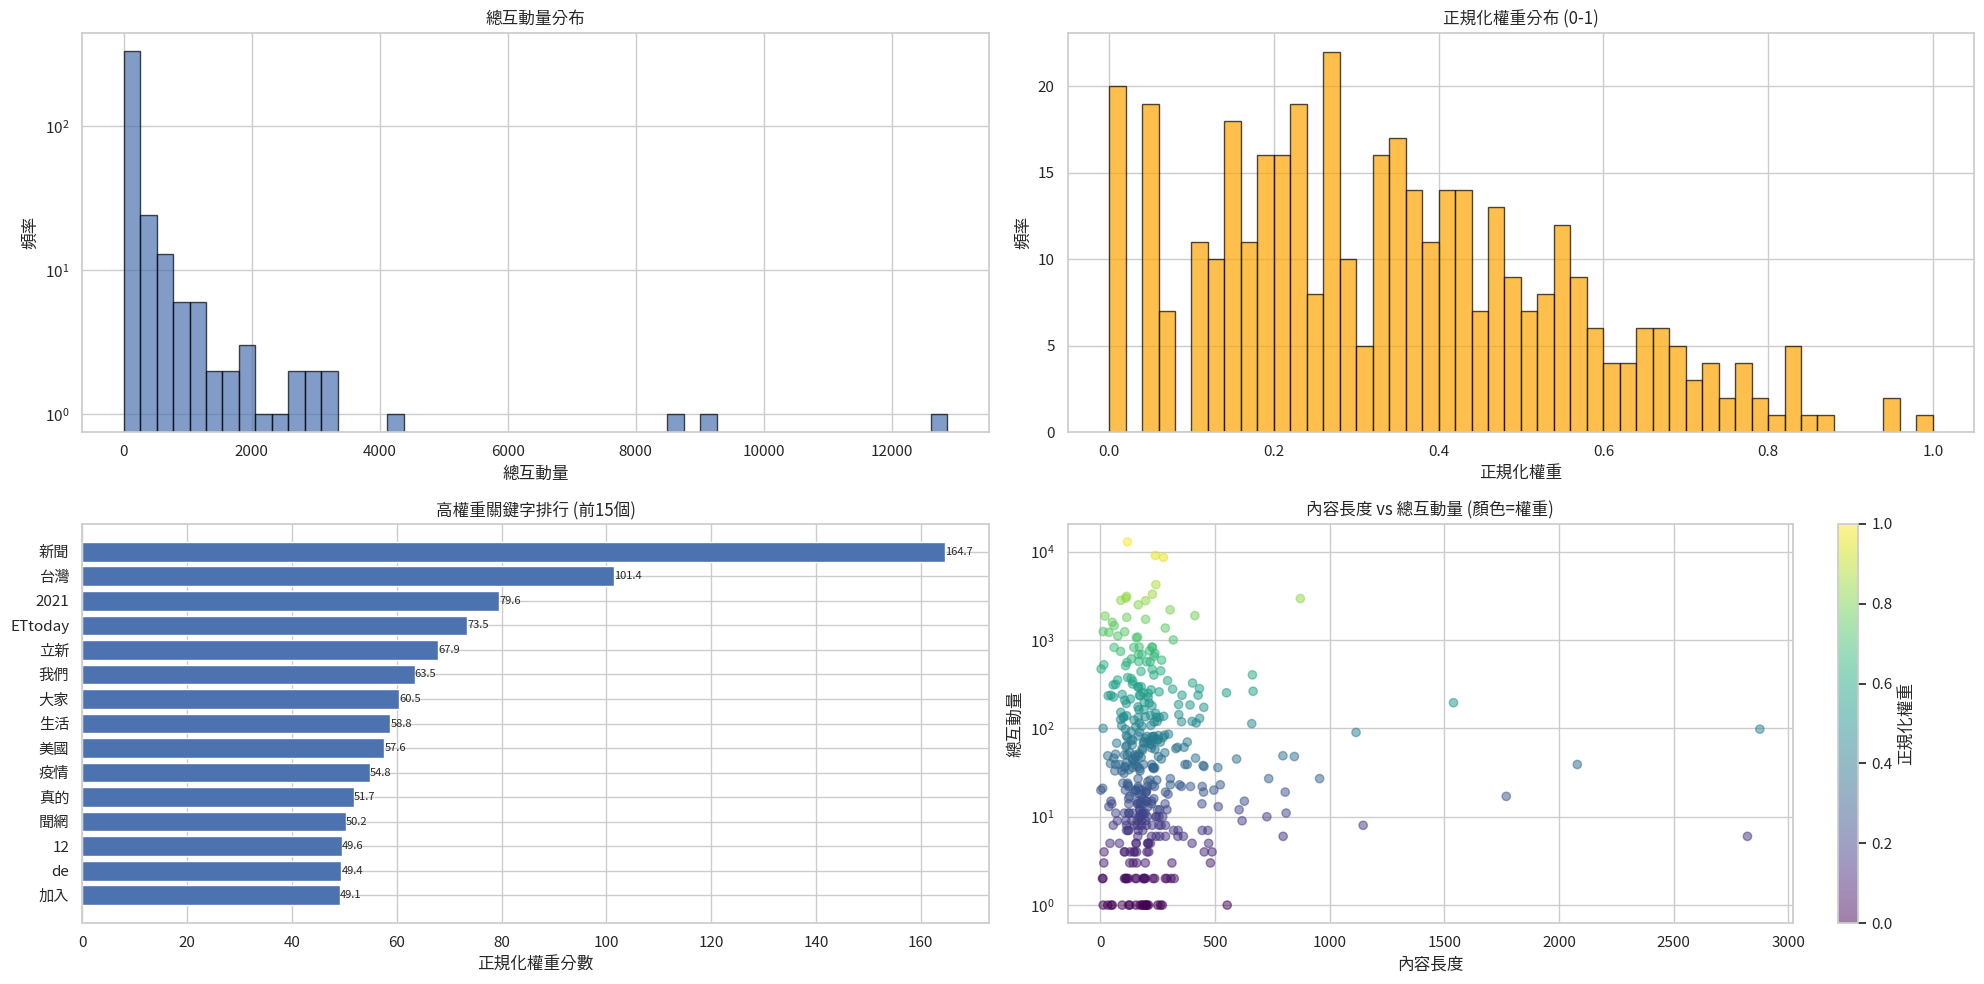


✅ 改進的加權關鍵字分析完成!
📊 主要改進:
   - 權重正規化至 0-1 範圍
   - 增加詞頻統計，提供更直觀的指標
   - 改進特有關鍵字的重要性計算
   - 增強視覺化效果

📁 已保存結果至:
   - normalized_weighted_keywords.csv (正規化權重關鍵字)
   - improved_distinctive_keywords.csv (改進的特有關鍵字)

📈 統計摘要:
   - 總詞彙數: 9406
   - 平均正規化權重: 2.557
   - 權重標準差: 4.665
   - 高互動特有詞彙數: 81


In [14]:
# 計算總互動量作為權重
merged_data['total_engagement'] = merged_data['reaction_all'] + merged_data['comment_count'] + merged_data['share_count']

# 對 total_engagement 做對數轉換避免極端值影響
merged_data['engagement_weight'] = np.log1p(merged_data['total_engagement'])

# 正規化權重到 0-1 範圍
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
merged_data['normalized_weight'] = scaler.fit_transform(merged_data[['engagement_weight']])

# 使用正規化權重調整TF-IDF特徵
weighted_tfidf = text_features.multiply(merged_data['normalized_weight'].values[:, None])

# 基於正規化權重的關鍵字分析
from collections import Counter
weighted_counter = Counter()
total_weight = 0
for idx, row in merged_data.iterrows():
    words = row['processed_content'].split()
    weight = row['normalized_weight']
    total_weight += weight
    for word in words:
        weighted_counter[word] += weight

# 計算平均權重並正規化分數
avg_weight = total_weight / len(merged_data)
normalized_counter = Counter()
for word, weight in weighted_counter.items():
    normalized_counter[word] = weight / avg_weight

# 取前40個高權重關鍵字
print("基於正規化互動量權重的熱門關鍵字 (前20個):")
for i, (word, norm_weight) in enumerate(normalized_counter.most_common(20), 1):
    # 計算詞頻
    word_freq = sum(1 for row in merged_data.itertuples() if word in row.processed_content.split())
    avg_engagement = weighted_counter[word] / word_freq if word_freq > 0 else 0
    print(f"{i:2d}. '{word}': 正規化權重 {norm_weight:.2f}, 出現次數 {word_freq}, 平均互動權重 {avg_engagement:.3f}")

# 分析高互動與低互動內容的關鍵字差異
high_engagement_threshold = merged_data['total_engagement'].quantile(0.75)
low_engagement_threshold = merged_data['total_engagement'].quantile(0.25)

high_engagement_content = merged_data[merged_data['total_engagement'] >= high_engagement_threshold]['processed_content'].str.cat(sep=' ')
low_engagement_content = merged_data[merged_data['total_engagement'] <= low_engagement_threshold]['processed_content'].str.cat(sep=' ')

high_words = Counter(high_engagement_content.split())
low_words = Counter(low_engagement_content.split())

# 找出在高互動內容中更常出現的關鍵字
distinctive_keywords = []
for word, high_freq in high_words.most_common(100):
    if len(word) >= 2:
        low_freq = low_words.get(word, 0)
        if high_freq > low_freq * 1.5:  # 降低閾值讓結果更豐富5:
            ratio = high_freq / max(low_freq, 1)
            # 計算相對重要性
            total_high = sum(high_words.values())
            total_low = sum(low_words.values())
            relative_importance = (high_freq/total_high) / max((low_freq/total_low), 0.001)
            distinctive_keywords.append((word, high_freq, low_freq, ratio, relative_importance))

distinctive_keywords.sort(key=lambda x: x[4], reverse=True)  # 按相對重要性排序sort(key=lambda x: x[4], reverse=True)

print(f"\n高互動內容特有關鍵字 (前15個):")
for i, (word, high_freq, low_freq, ratio, importance) in enumerate(distinctive_keywords[:15], 1):
    print(f"{i:2d}. '{word}': 高互動 {high_freq} vs 低互動 {low_freq}, 倍數 {ratio:.1f}, 重要性 {importance:.2f}")

# 創建加權的詞彙重要性分數彙重要性分數彙重要性分數
def calculate_weighted_word_importance(word, tfidf_vectorizer, weighted_tfidf_matrix):
    """計算詞彙的加權重要性分數"""
    try:
        word_idx = tfidf_vectorizer.vocabulary_.get(word)
        if word_idx is not None:
            # 計算該詞在所有文檔中的加權TF-IDF平均值
            word_scores = weighted_tfidf_matrix[:, word_idx].toarray().flatten()
            return np.mean(word_scores[word_scores > 0])
        return 0
    except:
        return 0

# 計算TF-IDF詞彙表中每個詞的加權重要性權重要性權重要性
vocab_importance = {}
for word in tfidf.vocabulary_:
    importance = calculate_weighted_word_importance(word, tfidf, weighted_tfidf)
    if importance > 0:
        vocab_importance[word] = importance

# 按重要性排序並正規化
if vocab_importance:
    max_importance = max(vocab_importance.values())
    vocab_importance = {word: (score/max_importance)*100 for word, score in vocab_importance.items()}
    sorted_vocab = sorted(vocab_importance.items(), key=lambda x: x[1], reverse=True)

    print(f"\nTF-IDF加權重要性詞彙 (前15個):")
    for i, (word, importance) in enumerate(sorted_vocab[:15], 1):
        print(f"{i:2d}. '{word}': 重要性分數 {importance:.1f}/100")

# 視覺化權重分布
plt.figure(figsize=(20, 10))

# 互動量分布
plt.subplot(2, 2, 1)
plt.hist(merged_data['total_engagement'], bins=50, alpha=0.7, edgecolor='black')
plt.title('總互動量分布')
plt.xlabel('總互動量')
plt.ylabel('頻率')
plt.yscale('log')

# 正規化權重分布
plt.subplot(2, 2, 2)
plt.hist(merged_data['normalized_weight'], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('正規化權重分布 (0-1)')
plt.xlabel('正規化權重')
plt.ylabel('頻率')

# 高權重關鍵字條形圖
plt.subplot(2, 2, 3)
top_normalized_words = [item[0] for item in normalized_counter.most_common(15)]
top_normalized_scores = [item[1] for item in normalized_counter.most_common(15)]
y_pos = np.arange(len(top_normalized_words))
bars = plt.barh(y_pos, top_normalized_scores)
plt.yticks(y_pos, top_normalized_words)
plt.xlabel('正規化權重分數')
plt.title('高權重關鍵字排行 (前15個)')
plt.gca().invert_yaxis()

# 為條形圖添加數值標籤
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', ha='left', va='center', fontsize=8)

# 互動量與內容長度關係
plt.subplot(2, 2, 4)
plt.scatter(merged_data['content_length'], merged_data['total_engagement'], 
           alpha=0.5, c=merged_data['normalized_weight'], cmap='viridis')
plt.xlabel('內容長度')
plt.ylabel('總互動量')
plt.title('內容長度 vs 總互動量 (顏色=權重)')
plt.yscale('log')
plt.colorbar(label='正規化權重')

plt.tight_layout()
plt.show()

# 保存改進的結果
# 正規化權重關鍵字
normalized_keywords_df = pd.DataFrame([
    {
        '關鍵字': word, 
        '正規化權重': weight,
        '出現次數': sum(1 for row in merged_data.itertuples() if word in row.processed_content.split()),
        '平均互動權重': weighted_counter[word] / sum(1 for row in merged_data.itertuples() if word in row.processed_content.split())
    }
    for word, weight in normalized_counter.most_common(50)
])

# 改進的特有關鍵字
improved_distinctive_df = pd.DataFrame(distinctive_keywords[:30], 
                                     columns=['關鍵字', '高互動頻率', '低互動頻率', '頻率比率', '相對重要性'])

# 保存檔案
normalized_keywords_df.to_csv('normalized_weighted_keywords.csv', index=False, encoding='utf-8')
improved_distinctive_df.to_csv('improved_distinctive_keywords.csv', index=False, encoding='utf-8')

print(f"\n✅ 改進的加權關鍵字分析完成!")
print(f"📊 主要改進:")
print(f"   - 權重正規化至 0-1 範圍")
print(f"   - 增加詞頻統計，提供更直觀的指標")
print(f"   - 改進特有關鍵字的重要性計算")
print(f"   - 增強視覺化效果")
print(f"\n📁 已保存結果至:")
print(f"   - normalized_weighted_keywords.csv (正規化權重關鍵字)")
print(f"   - improved_distinctive_keywords.csv (改進的特有關鍵字)")

# 輸出統計摘要
print(f"\n📈 統計摘要:")
print(f"   - 總詞彙數: {len(weighted_counter)}")
print(f"   - 平均正規化權重: {np.mean(list(normalized_counter.values())):.3f}")
print(f"   - 權重標準差: {np.std(list(normalized_counter.values())):.3f}")
print(f"   - 高互動特有詞彙數: {len(distinctive_keywords)}")

In [60]:
# 釋放 Milvus 資源
try:
    news_posts.release()
    cluster_centroids.release()
    print("成功釋放 Milvus 集合資源")
    
    # 斷開與 Milvus 的連接
    connections.disconnect("default")
    print("成功斷開 Milvus 連接")
except Exception as e:
    print(f"釋放資源時出錯: {e}")

成功釋放 Milvus 集合資源
成功斷開 Milvus 連接
